## **Introduction**

K-means clustering is very effective when segmenting data and attempting to find patterns.

In this activity, a scientific organization is working to support and sustain penguin colonies. They are helping other staff members learn more about penguins. The data for this activity is in a spreadsheet that includes datapoints across a sample size of 345 penguins, such as species, island, and sex. Use a K-means clustering model to group this data and identify patterns that provide important insights about penguins.

## **Step 1: Imports** 

In [3]:
# Import standard operational packages.
import numpy as np
import pandas as pd

# Important tools for modeling and evaluation.
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Import visualization packages.
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
penguins = pd.read_csv("penguins.csv")
penguins.head(n = 10)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male
6,Adelie,Torgersen,38.9,17.8,181.0,3625.0,female
7,Adelie,Torgersen,39.2,19.6,195.0,4675.0,male
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN


## **Step 2: Data exploration** 

After loading the dataset, the next step is to prepare the data to be suitable for clustering. This includes: 

*   Exploring data
*   Checking for missing values
*   Encoding data 
*   Dropping a column
*   Scaling the features using `StandardScaler`

### Explore data

In [5]:
penguins['species'].unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [6]:
penguins['species'].value_counts(dropna = False)

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

There are three types of species. Note the Chinstrap species is less common than the other species. This has a chance to affect K-means clustering as K-means performs best with similar sized groupings.

### Check for missing values

An assumption of K-means is that there are no missing values. 

In [7]:
penguins.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [8]:
penguins_subset = penguins.dropna(axis=0).reset_index(drop = True)
penguins_subset

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male
...,...,...,...,...,...,...,...
328,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,female
329,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,female
330,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,male
331,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,female


In [9]:
# Check for missing values.
penguins_subset.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [10]:
penguins_subset.head(10)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male
5,Adelie,Torgersen,38.9,17.8,181.0,3625.0,female
6,Adelie,Torgersen,39.2,19.6,195.0,4675.0,male
7,Adelie,Torgersen,41.1,17.6,182.0,3200.0,female
8,Adelie,Torgersen,38.6,21.2,191.0,3800.0,male
9,Adelie,Torgersen,34.6,21.1,198.0,4400.0,male


### Encode data

Some versions of the penguins dataset have values encoded in the sex column as 'Male' and 'Female' instead of 'MALE' and 'FEMALE'. The code below will make sure all values are ALL CAPS. 


In [11]:
penguins_subset['sex'] = penguins_subset['sex'].str.upper()

K-means needs numeric columns for clustering. The categorical column `'sex'` has to be converted into numeric. There is no need to convert the `'species'` column because it isn't being used as a feature in the clustering algorithm. 

In [12]:
penguins_subset = pd.get_dummies(penguins_subset, drop_first = True, columns=['sex'])

### Drop a column

Drop the categorical column `island` from the dataset. While it has value, this notebook is trying to confirm if penguins of the same species exhibit different physical characteristics based on sex. This doesn't include location.
Note that the `'species'` column is not numeric. We will not drop the `'species'` column for now. It could potentially be used to help understand the clusters later. 

In [13]:
penguins_subset = penguins_subset.drop(['island'], axis=1)

### Scale the features

Because K-means uses distance between observations as its measure of similarity, it's important to scale the data before modeling. Use a third-party tool, such as scikit-learn's `StandardScaler` function. `StandardScaler` scales each point xᵢ by subtracting the mean observed value for that feature and dividing by the standard deviation:

$ x-scaled = \frac{xᵢ – mean(X)}{\sigma}$

This ensures that all variables have a mean of 0 and variance/standard deviation of 1. 

**Note:** Because the species column isn't a feature, it doesn't need to be scaled. 

In [16]:
X = penguins_subset.drop(['species'], axis=1)
X_scaled = StandardScaler().fit_transform(X)

## **Step 3: Data modeling** 

Now, fit K-means and evaluate inertia for different values of k. Because we do not know how many clusters exist in the data, start by fitting K-means and examining the inertia values for different values of k. To do this, write a function called `kmeans_inertia` that takes in `num_clusters` and `x_vals` (`X_scaled`) and returns a list of each k-value's inertia.

Set the `random_state` to `42` for reproducibility of results.

In [17]:
num_clusters = [i for i in range(2, 11)]

def kmeans_inertia(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array. 
    Fits a KMeans model where k = each value in the list of ints. 
    Returns each k-value's inertia appended to a list.
    """
    inertia = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)

    return inertia

In [18]:
inertia = kmeans_inertia(num_clusters, X_scaled)
inertia

/Users/sagarikasardesai/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/sagarikasardesai/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/sagarikasardesai/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/sagarikasardesai/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: 

[885.6224143652249,
 578.8284278107235,
 386.1453442477329,
 284.5464837898288,
 217.94583355138298,
 201.39287843423264,
 185.60496834757078,
 173.28480307333598,
 167.27056216926854]

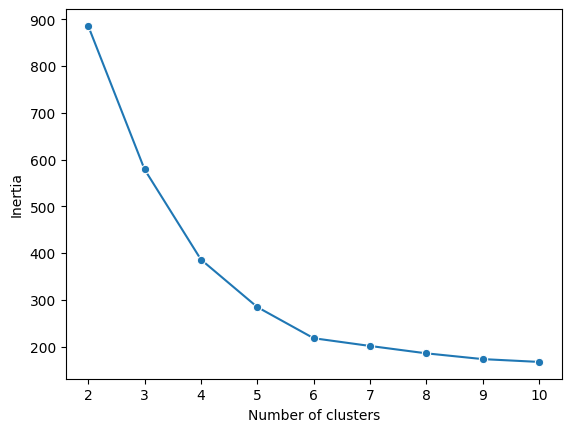

In [19]:
plot = sns.lineplot(x=num_clusters, y=inertia, marker = 'o')
plot.set_xlabel("Number of clusters");
plot.set_ylabel("Inertia");

The plot seems to depict an elbow at six clusters, but there isn't a clear method for confirming that a six-cluster model is optimal. Therefore, the silhouette scores should be checked. 

## **Step 4: Results and evaluation** 

Now, evaluate the silhouette score using the `silhouette_score()` function. Silhouette scores are used to study the distance between clusters. 

Then, compare the silhouette score of each value of k, from 2 through 10. To do this, write a function called `kmeans_sil` that takes in `num_clusters` and `x_vals` (`X_scaled`) and returns a list of each k-value's silhouette score.

In [20]:
def kmeans_sil(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array. 
    Fits a KMeans model where k = each value in the list of ints.
    Calculates a silhouette score for each k value. 
    Returns each k-value's silhouette score appended to a list.
    """
    sil_score = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        sil_score.append(silhouette_score(x_vals, kms.labels_))

    return sil_score

sil_score = kmeans_sil(num_clusters, X_scaled)
sil_score

/Users/sagarikasardesai/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/sagarikasardesai/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/sagarikasardesai/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/sagarikasardesai/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: 

[0.44398088353055243,
 0.45101024097188364,
 0.5080140996630784,
 0.519998574860868,
 0.5257260332987352,
 0.47774022332151733,
 0.4213887558059968,
 0.3611605069259161,
 0.4036132056908919]

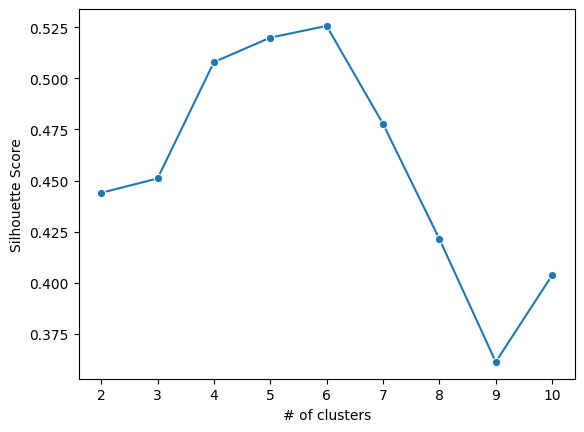

In [21]:
#line plot that shows the relationship between num_clusters and sil_score
plot = sns.lineplot(x=num_clusters, y=sil_score, marker = 'o')
plot.set_xlabel("# of clusters");
plot.set_ylabel("Silhouette Score");

Silhouette scores near 1 indicate that samples are far away from neighboring clusters. Scores close to 0 indicate that samples are on or very close to the decision boundary between two neighboring clusters. 

The plot indicates that the silhouette score is closest to 1 when the data is partitioned into six clusters, although five clusters also yield a relatively good silhouette score.

### Optimal k-value

In [22]:
kmeans6 = KMeans(n_clusters=6, random_state=42)
kmeans6.fit(X_scaled)

/Users/sagarikasardesai/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=6, random_state=42)

In [23]:
print('Unique labels:', np.unique(kmeans6.labels_))

Unique labels: [0 1 2 3 4 5]


Now, create a new column `cluster` that indicates cluster assignment in the DataFrame `penguins_subset`. It's important to understand the meaning of each cluster's labels, then decide whether the clustering makes sense. 

**Note:** This task is done using `penguins_subset` because it is often easier to interpret unscaled data.

In [24]:
penguins_subset['cluster'] = kmeans6.labels_
penguins_subset.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_MALE,cluster
0,Adelie,39.1,18.7,181.0,3750.0,True,0
1,Adelie,39.5,17.4,186.0,3800.0,False,2
2,Adelie,40.3,18.0,195.0,3250.0,False,2
3,Adelie,36.7,19.3,193.0,3450.0,False,2
4,Adelie,39.3,20.6,190.0,3650.0,True,0


In [25]:
penguins_subset.groupby(by=['cluster', 'species']).size()

cluster  species  
0        Adelie       70
1        Gentoo       58
2        Adelie       73
         Chinstrap     5
3        Gentoo       61
4        Chinstrap    29
5        Adelie        3
         Chinstrap    34
dtype: int64

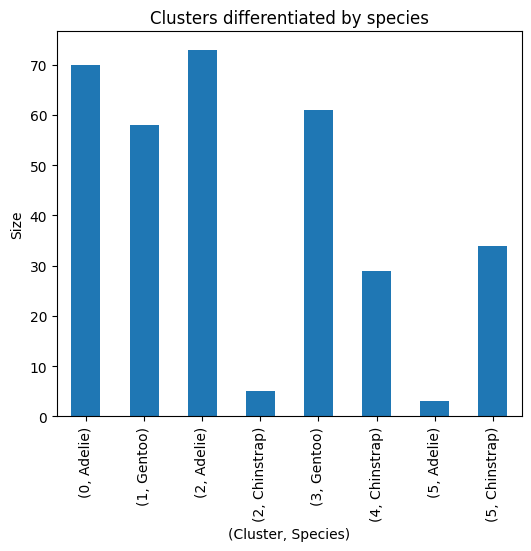

In [26]:
penguins_subset.groupby(by=['cluster', 'species']).size().plot.bar(title='Clusters differentiated by species',
                                                                   figsize=(6, 5),
                                                                   ylabel='Size',
                                                                   xlabel='(Cluster, Species)');

In [27]:
# Verify if each `cluster` can be differentiated by `species` AND `sex_MALE`.
penguins_subset.groupby(by=['cluster','species', 'sex_MALE']).size().sort_values(ascending = False)

cluster  species    sex_MALE
2        Adelie     False       73
0        Adelie     True        70
3        Gentoo     True        61
1        Gentoo     False       58
5        Chinstrap  True        34
4        Chinstrap  False       29
2        Chinstrap  False        5
5        Adelie     True         3
dtype: int64

Even though clusters 1 and 3 weren't all one species or sex, the `groupby` indicates that the algorithm produced clusters mostly differentiated by species and sex. 

The graph shows that each `'cluster'` can be differentiated by `'species'` and `'sex_MALE'`. Furthermore, each cluster is mostly comprised of one sex and one species. 

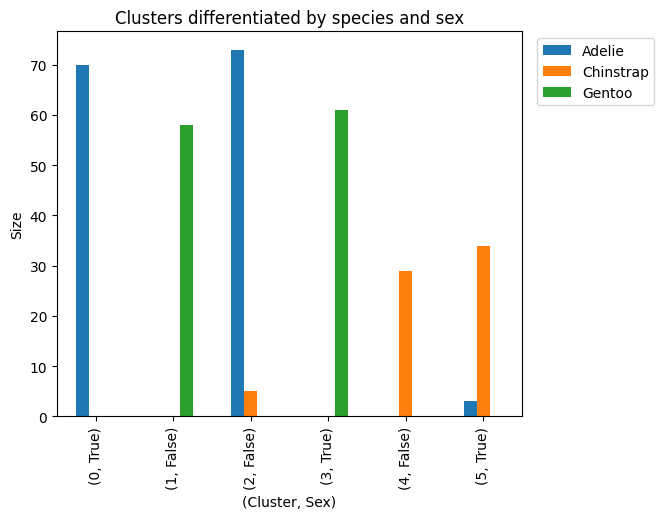

In [28]:
penguins_subset.groupby(by=['cluster','species','sex_MALE']).size().unstack(level = 'species', fill_value=0).plot.bar(title='Clusters differentiated by species and sex',
                                                                                                                      figsize=(6, 5),
                                                                                                                      ylabel='Size',
                                                                                                                      xlabel='(Cluster, Sex)')
plt.legend(bbox_to_anchor=(1.3, 1.0))